Packages

In [1]:
import pandas as pd
import numpy as np

import functools
from typing import Any, Tuple

import scipy.signal as scipy_signal

from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px

In [ ]:
#pip install finufft

In [2]:
import finufft

Data import and cleaning

In [2]:
df_NO2 = pd.read_csv("train_val_split/observation_filtered.csv")

In [4]:
df_NO2.head(6)

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,period,season,type,date,time,year,day,tot_hour_numeric,tot_min_numeric,tot_min_rounded
0,16091,2017-02-17 12:31:29,173565,-79.977161,40.430140,225.968182,12,517.372273,0.422173,17.615000,...,2,3,4,2017-02-17,12:31:29,2017,17,4634.608056,278076.483333,278076.0
1,10634,2017-02-02 09:50:38,122180,-79.997926,40.441055,274.931818,9,499.572350,0.137255,8.555914,...,1,3,4,2017-02-02,09:50:38,2017,2,4271.927222,256315.633333,256316.0
2,2485,2016-09-20 20:57:59,35619,-79.907425,40.490618,NaN,20,469.582763,0.552017,1.452951,...,3,1,3,2016-09-20,20:57:59,2016,20,1043.049722,62582.983333,62583.0
3,14692,2017-02-15 06:21:22,165359,-80.005746,40.438416,236.300000,6,520.905352,0.232678,3.899478,...,1,3,4,2017-02-15,06:21:22,2017,15,4580.439444,274826.366667,274826.0
4,8847,2017-01-31 12:04:59,115153,-79.956671,40.459469,295.581818,12,477.227354,0.121132,30.380059,...,2,3,3,2017-01-31,12:04:59,2017,31,4226.166389,253569.983333,253570.0
5,4193,2016-11-18 15:24:01,60,-80.079202,40.408026,255.568182,15,455.181827,0.441932,7.983373,...,2,2,3,2016-11-18,15:24:01,2016,18,2453.483611,147209.016667,147209.0


Average observations that fall into the same minute category so that we have one row per observed minute (for the short-time Fourier transform)

In [5]:
min_avg_NO2 = df_NO2.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()
min_avg_NO2.head()
#min_avg_NO2['tot_min_rounded'].max()

,tot_min_rounded,datetime,NO2
0,1.0,2016-08-08 09:56:02,13.752167
1,2.0,2016-08-08 09:56:59,14.866519
2,4.0,2016-08-08 09:59:00,11.266365
3,5.0,2016-08-08 10:00:01,11.102795
4,6.0,2016-08-08 10:01:00,10.909147


Examine the spacing of the sampling

In [6]:
# Sort the DataFrame based on the column with integers
sorted_df = min_avg_NO2.sort_values(by='tot_min_rounded')

# Get the differences between consecutive values
diff = sorted_df['tot_min_rounded'].diff()

# Find where the differences are greater than 2 indicating a larger gap
gaps = diff[diff > 2]

# Compute the number of missing integers in each gap
missing_counts = gaps - 1

# Displaying the number of missing integers in each gap
print(missing_counts)

33         3.0
45      1002.0
55        55.0
59         6.0
60         2.0
         ...  
4477      50.0
4502      23.0
4596     492.0
4679    2204.0
4923     678.0
Name: tot_min_rounded, Length: 207, dtype: float64


In [29]:
# Remove one observation so that data has an odd number of observations - can't 
# get the calculation of the Fourier transform coefficients to with even
min_avg_NO2 = min_avg_NO2[1:]
print(min_avg_NO2.shape)

(5129, 4)


# Info on Non-uniform discrete Fourier Transform

The nonuniform discrete Fourier transform of type II (NUDFT-II) uses uniform (i.e. integer) frequencies but nonuniform sample points p_{n}. This corresponds to evaluating a Fourier series at nonequispaced points. It is also known as adjoint NDFT. In the FINUFFT package implementation this is called the "type 1" NUFFT.

## Example code from finufft documentation

In [30]:
# number of nonuniform points
M = 100

# the nonuniform points
x = 2 * np.pi * np.random.uniform(size=M)

# their complex strengths
c = (np.random.standard_normal(size=M)
    + 1J * np.random.standard_normal(size=M))

## Code for one day of data

In [31]:
# Convert column named 'datetime' to actual datetime
min_avg_NO2['datetime'] = pd.to_datetime(min_avg_NO2['datetime'])

# add day of year 
min_avg_NO2['day_of_year'] = min_avg_NO2['datetime'].dt.dayofyear

#see which days are included
min_avg_NO2.groupby('day_of_year').count()

day33 = min_avg_NO2[min_avg_NO2['day_of_year'] == 33]
day33.head()

/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_41972/2006467439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_avg_NO2['datetime'] = pd.to_datetime(min_avg_NO2['datetime'])
/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_41972/2006467439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_avg_NO2['day_of_year'] = min_avg_NO2['datetime'].dt.dayofyear


,tot_min_rounded,datetime,NO2,day_of_year
3320,256063.0,2017-02-02 05:38:05,7.844182,33
3321,256064.0,2017-02-02 05:39:09,7.791027,33
3322,256065.0,2017-02-02 05:40:13,7.606351,33
3323,256066.0,2017-02-02 05:40:34,7.524876,33
3324,256067.0,2017-02-02 05:41:38,7.555510,33


In [32]:
#see example code at https://finufft.readthedocs.io/en/latest/python.html
c = day33['NO2'] #set the signal "strengths" to the observed outcome
c_complex = np.array([complex(num, 0) for num in c])



#need to normalize x to fall within [-3 pi , 3pi]
x = day33['tot_min_rounded'] #location of observations
x_norm = 2 * np.pi * (x - np.min(x))/(np.max(x) - np.min(x))

N = len(day33['NO2']//2) #number of desired Fourier modes

print(x_norm)

3320    0.000000
3321    0.019821
3322    0.039642
3323    0.059462
3324    0.079283
          ...   
3629    6.203902
3630    6.223723
3631    6.243544
3632    6.263365
3633    6.283185
Name: tot_min_rounded, Length: 314, dtype: float64


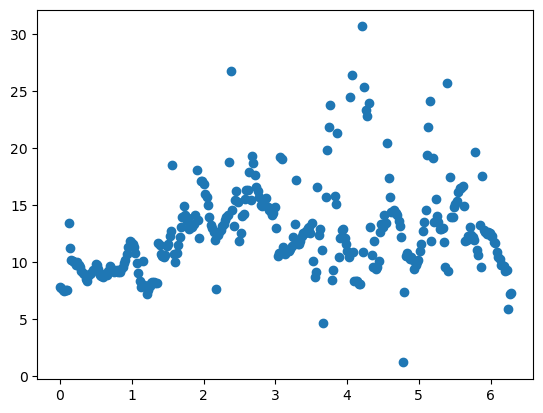

In [33]:
plt.scatter(x = x_norm, y = c)

In [34]:
x_norm = np.ascontiguousarray(x_norm)
c_complex = np.ascontiguousarray(c_complex)

# calculate the type-1 NUFFT
f = finufft.nufft1d1(x_norm, c_complex, N)




Find coefficients

In [36]:
#data is indexed by -N1/2 <= k1 <= (N1-1)/2 
#a_n = 2*f.real
#b_n = -2*f.imag


k_neg = np.flip(f[1: len(f)//2])
k_pos = f[len(f)//2 + 1:]
print(len(f),len(k_neg), len(k_pos))

C_n = np.abs(k_neg)**2 + np.abs(k_pos)**2
print(C_n)



314 156 156
[2.48697393e+05 1.74671941e+05 1.28836070e+04 4.70286490e+04
 4.34936457e+04 2.60932387e+03 2.45781102e+04 3.71691993e+03
 1.52788186e+04 1.17418528e+04 4.85969354e+02 8.34963447e+03
 8.24586989e+03 7.99345535e+04 2.22608716e+04 1.67830849e+04
 1.39670292e+04 1.15568270e+04 8.18606914e+03 2.36866087e+04
 6.46113482e+03 2.42440377e+04 2.78063039e+04 1.08492900e+04
 8.85734548e+03 1.11903769e+04 2.08713073e+04 3.78431658e+04
 1.18626164e+04 9.05291691e+03 3.20658144e+03 4.41413345e+03
 6.95275484e+03 2.67014564e+03 5.47801135e+02 3.78748585e+02
 2.60630141e+04 1.98988351e+04 6.77432325e+03 2.32719987e+04
 2.00473259e+04 3.10573075e+03 3.37041166e+03 4.94505506e+03
 2.04779170e+04 1.07018602e+04 1.03593413e+04 2.01565369e+03
 9.18310596e+03 2.28587781e+03 1.21280247e+04 6.61953870e+03
 1.43728664e+03 5.34709533e+03 1.44675486e+04 1.66596119e+04
 1.17184216e+04 2.40563214e+04 1.77216940e+04 2.49825963e+03
 8.15154570e+03 2.71370674e+03 1.91638232e+03 1.20559642e+04
 6.53447554e

Plot An and Bn

In [16]:
len(f)//2
157 + 157

314

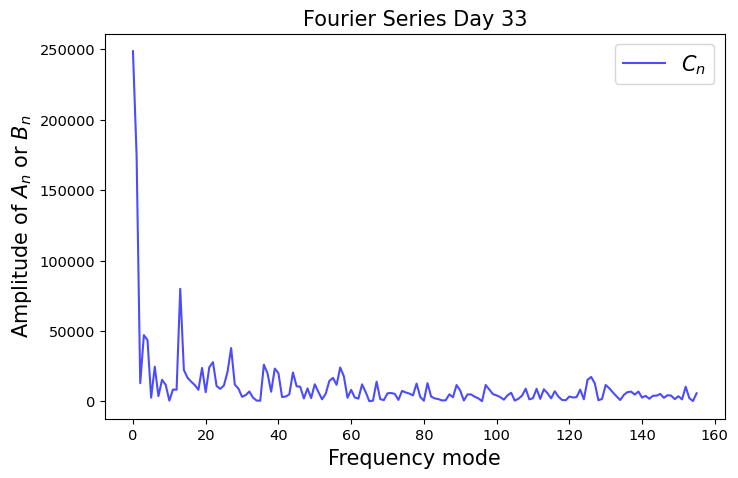

In [37]:
x_val = range(0, len(C_n))

fontsize = 15

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
#plt.plot(x_val, a_n, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
#plt.plot(x_val, b_n, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)
plt.plot(x_val, C_n, label=r'$C_n$', color = "blue", ms = 6, alpha = 0.7)

plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency mode', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Fourier Series Day 33', fontsize=fontsize)
plt.show()

In [18]:
np.argsort(-C_n)[0:20,]

array([  0,   1,   2,  14,   4,  13,   3,  27,  22,  28,   5,  37,  40,
        58,  15,  23,  57, 126,  26,  19])

In [19]:
#total number of minutes of sampling for day 33
mins_in_day33 = max(day33['tot_min_rounded']) - min(day33['tot_min_rounded'])
mins_in_day33

317.0

In [ ]:
# frequencies with highest vals of coeffs in minutes
mins_in_day33/13
mins_in_day33/3

From this we can see that we have a daily trend, a 1/13th day trend, a 1/3 day trend and a 1/21 day trend. Where "day" is the entire study period for which I have data on day 33, ie 317 minutes. 

### Reconstruct the signal from the frequencies

## Code for NO2 data

In [38]:
c = min_avg_NO2['NO2'] #set the signal "strengths" to the observed outcome
c_complex = np.array([complex(num, 0) for num in c])



#need to normalize x to fall within [-3 pi , 3pi]
x = min_avg_NO2 ['tot_min_rounded'] #location of observations
x_norm = 1 * np.pi * (x - np.min(x))/(np.max(x) - np.min(x))

N = len(min_avg_NO2 ['NO2']//2) #number of desired Fourier modes
print(x_norm)

1       0.000000
2       0.000023
3       0.000034
4       0.000045
5       0.000056
          ...   
5125    3.141547
5126    3.141559
5127    3.141570
5128    3.141581
5129    3.141593
Name: tot_min_rounded, Length: 5129, dtype: float64


In [39]:
x_norm = np.ascontiguousarray(x_norm)
c_complex = np.ascontiguousarray(c_complex)

# calculate the type-1 NUFFT
f = finufft.nufft1d1(x_norm, c_complex, N)

In [47]:
#check indexing of Cn makes sense
2564 + 1 + 2564

5129

In [48]:
# coefficients
print(len(f)//2)
k_neg = np.flip(f[1: len(f)//2 + 1])
k_pos = f[len(f)//2 + 1:]
print(len(f),len(k_neg), len(k_pos))

C_n = np.abs(k_neg)**2 + np.abs(k_pos)**2
print(C_n)


2564
5129 2564 2564
[4.45789004e+09 2.71229687e+09 2.79334347e+09 ... 1.90151777e+07
 2.26827778e+07 2.28587711e+07]


Plot fourier coefficient

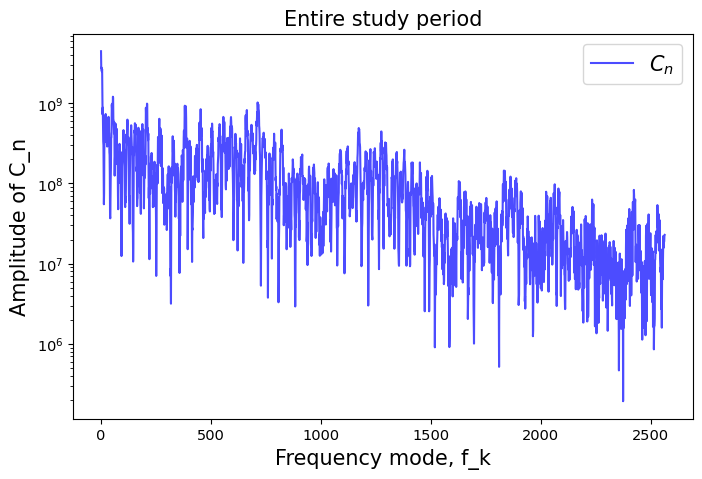

In [54]:
x_val = range(0, len(C_n))

fontsize = 15

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
#plt.plot(x_val, a_n, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
#plt.plot(x_val, b_n, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)
# convert y-axis to Logarithmic scale 
plt.yscale("log")   

plt.plot(x_val, C_n, label=r'$C_n$', color = "blue", ms = 6, alpha = 0.7)

plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of C_n', fontsize=fontsize)
plt.xlabel('Frequency mode, f_k', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Entire study period', fontsize=fontsize)
plt.show()

In [50]:
np.argsort(-C_n)[0:50]

array([  0,   2,   1,   5,   4,   3,   6,  54,  55, 712,  52, 209, 210,
       715,  49, 713, 381, 386,   8, 204,  51,  50, 453,  53, 663, 716,
       714, 717, 718, 710,  21,   7, 711, 658,  20,  17, 662, 382, 205,
        34, 556, 591, 385, 557, 387, 657, 380, 265, 452, 709])

In [59]:
# need to reverse the normalization to find the important periodicity
#x_norm = 1 * np.pi * (x - np.min(x))/(np.max(x) - np.min(x))
total_mins = max(min_avg_NO2['tot_min_rounded']) - min(min_avg_NO2['tot_min_rounded']) #total study period
print(total_mins)
fk_unnorm = C_n * total_mins / np.pi 

print(np.argsort(-fk_unnorm)[0:50])

#periodicity is to 1/f * study period 
p_hours = 1 / np.argsort(-fk_unnorm)[1:15] * total_mins / 60 #in hours
p_days = 1 / np.argsort(-fk_unnorm)[1:15] * total_mins / 60 * 1/24 #in days
print(p_hours)
print(p_days)


278175.0
[  0   2   1   5   4   3   6  54  55 712  52 209 210 715  49 713 381 386
   8 204  51  50 453  53 663 716 714 717 718 710  21   7 711 658  20  17
 662 382 205  34 556 591 385 557 387 657 380 265 452 709]
[2318.125      4636.25        927.25       1159.0625     1545.41666667
  772.70833333   85.85648148   84.29545455    6.51158708   89.15865385
   22.18301435   22.07738095    6.48426573   94.61734694]
[ 96.58854167 193.17708333  38.63541667  48.29427083  64.39236111
  32.19618056   3.5773534    3.51231061   0.27131613   3.71494391
   0.92429226   0.91989087   0.27017774   3.94238946]


Based on this, it looks like there is periodicity at ~ 193 days (seasonal), ~ 3.6 days (weekly), ~ 6.5 hours (daily), and 22 hours (daily) 

In [60]:
#In minutes, that is
print("~193.18 days is: ", 193.18 * 60 * 24, "mins")
print("3.6 days is : ", 3.6 * 60 * 24, "mins")
print("6.5 hours is: ", 6.5 * 60, "mins")
print("22.1 hours is:", 22.2 * 60, "mins")


~193.18 days is:  278179.2 mins
3.6 days is :  5184.0 mins
6.5 hours is:  390.0 mins
22.1 hours is: 1332.0 mins
